In [26]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
df = pd.read_csv("commuting_with_cluster_percentage.csv")

print(df.head())
print(df.info())


   percentage_0  percentage_1_14  percentage_15_29  percentage_30_44  \
0          0.00            17.65             29.68             31.28   
1          4.53             3.30             52.18             33.34   
2          2.96            55.56             27.97              7.36   
3          5.77            18.83             29.98             21.08   
4          8.12            52.14              5.56             32.05   

   percentage_under45  percentage_45_59  percentage_60  percentage_over45  \
0               78.61              1.34          20.05              21.39   
1               93.35              0.43           6.22               6.65   
2               93.85              2.45           3.70               6.15   
3               75.66             10.59          13.75              24.34   
4               97.87              0.85           1.28               2.13   

        Region cluster_label urbanisation_degree        education_level  \
0       Latvia        Low-HO 

In [28]:
for col in ["education_level", "urbanisation_degree", "cluster_label"]:
    print(col, df[col].unique())

education_level ['ISCED 3–4' 'ISCED 5–8' 'ISCED 0–2' 'All ISCED 2011 levels']
urbanisation_degree ['Cities' 'Total' 'Rural areas' 'Towns and suburbs' 'No response']
cluster_label ['Low-HO' 'Mid-HO' 'High-HO']


In [29]:
# Drop rows
df = df[
    (~df['education_level'].str.contains("All ISCED", case=False, na=False)) &
    (~df['urbanisation_degree'].str.contains("Total", case=False, na=False)) &
    (~df['urbanisation_degree'].str.contains("No response", case=False, na=False))
]

# Reset index
df = df.reset_index(drop=True)



In [30]:
print(df['urbanisation_degree'].unique())
print(df['education_level'].unique())


['Cities' 'Towns and suburbs' 'Rural areas']
['ISCED 3–4' 'ISCED 5–8' 'ISCED 0–2']


In [31]:
for col in ["education_level", "urbanisation_degree", "cluster_label", "Region"]:
    df[col] = df[col].astype("category")


In [32]:
df['percentage_over45'] = pd.to_numeric(df['percentage_over45'], errors='coerce')

In [ ]:
# model with interaction
md = smf.mixedlm(
    "percentage_over45 ~ C(education_level) * C(urbanisation_degree) * C(cluster_label)",
    data=df,
    groups=df["Region"],          
    re_formula="~1"
)
mfit = md.fit()
print(mfit.summary())


                                                       Mixed Linear Model Regression Results
Model:                                        MixedLM                             Dependent Variable:                             percentage_over45
No. Observations:                             697                                 Method:                                         REML             
No. Groups:                                   23                                  Scale:                                          49.1496          
Min. group size:                              4                                   Log-Likelihood:                                 -2319.7342       
Max. group size:                              54                                  Converged:                                      Yes              
Mean group size:                              30.3                                                                                                 
-------------------

In [36]:
#model without interaction
md = smf.mixedlm(
    "percentage_over45 ~ C(education_level) + C(urbanisation_degree) + C(cluster_label)",
    data=df,
    groups=df["Region"]
)
mfit = md.fit()
print(mfit.summary())



                        Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        percentage_over45
No. Observations:          697            Method:                    REML             
No. Groups:                23             Scale:                     51.5243          
Min. group size:           4              Log-Likelihood:            -2379.0962       
Max. group size:           54             Converged:                 Yes              
Mean group size:           30.3                                                       
--------------------------------------------------------------------------------------
                                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------
Intercept                                    9.307    2.123  4.384 0.000  5.146 13.468
C(education_level)[T.ISCED 3–4]              4.659    0.840  5.545 0

Education matters a lot: higher education strongly predicts longer commutes (very significant).

Urbanisation also matters: people in cities commute longer than those in rural/towns.

HO cluster is not significant here → whether a country is high/low/mid home-office doesn’t affect long commuting rates much once you control for education and urbanisation.

Random effects: variance across countries still meaningful (countries differ beyond education/urbanisation)

C:\Users\david\AppData\Local\Temp\ipykernel_21564\1967337385.py:14: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(


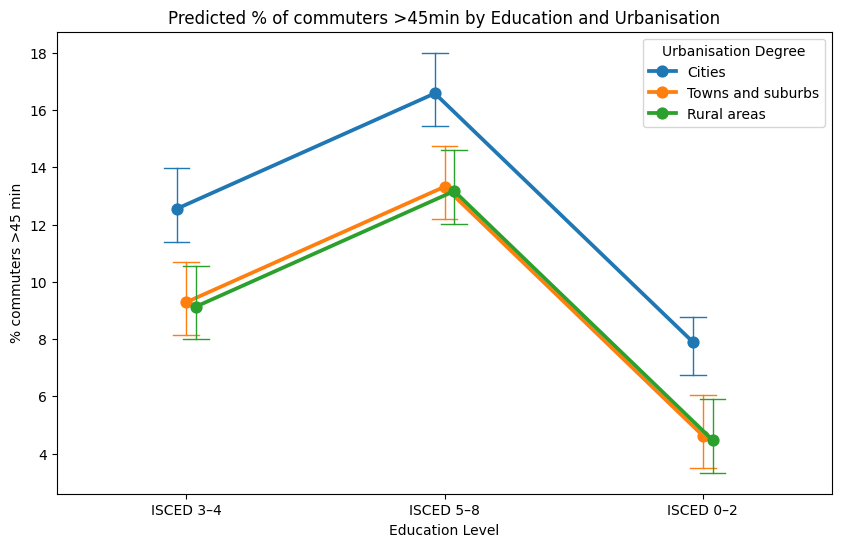

In [37]:
pred_df = pd.DataFrame([
    (edu, urb, clust, reg)
    for edu in df["education_level"].unique()
    for urb in df["urbanisation_degree"].unique()
    for clust in df["cluster_label"].unique()
    for reg in df["Region"].unique()[:1]  # pick 1 region just for prediction baseline
], columns=["education_level", "urbanisation_degree", "cluster_label", "Region"])

# Get predicted means
pred_df["predicted"] = mfit.predict(pred_df)

# Plot: Education × Urbanisation, colored by cluster
plt.figure(figsize=(10,6))
sns.pointplot(
    data=pred_df,
    x="education_level",
    y="predicted",
    hue="urbanisation_degree",
    dodge=True,
    markers="o",
    capsize=.1,
    errwidth=1,
)
plt.title("Predicted % of commuters >45min by Education and Urbanisation")
plt.ylabel("% commuters >45 min")
plt.xlabel("Education Level")
plt.legend(title="Urbanisation Degree")
plt.show()